# EE372 Lecture 12 notes: RNA-Seq Quantification

### Problem Setup

Recall from last lecture, humans have about 20,000 genes, each one made up of introns and exons. The exons are appended to each other in various orders to form isoforms, which are sequences on strands of RNA. In humans, there are about 120,000 known isoforms, and the isoforms are on the order of 1k-10k basepairs long. However, for any given cell or tissue, the expression levels of genes are different, and therefore the relative abundance of isoforms will be different as well.

In the RNA-seq problem, the objective is to estimate the relative abundance of isoforms given reads sampled from the isoforms present in the cell(s). The difficulty arises in the fact that a single read can be mapped to more than one of the known isoforms from the reference transcriptome, and so is more complicated than simply counting up the reads.

More formally, we are interested in estimating $\rho_1, \dots, \rho_k$, the relative abundances of the isoforms in the cell(s).  

### Pipeline

The pipeline is 

Reads $\longrightarrow$ Alignment $\longrightarrow$ Possible transcripts the read could have come from

In the following example, we make the simplifying assumptions when considering what transcripts each read could have come from

#### Assumptions
1. Each transcript is the same length
2. Each read is the same length
3. Each read can appear at most once in each transcript
4. Each read is uniformly sampled from a transcript

### Example 1: Same length transcripts

Consider two transcripts, $t_1$ and $t_2$ with ground truth relative abundances $\rho_1$ and $\rho_2$.

$t_1$ is made up of exon A and then exon B. 

$t_2$ is made up of exon B and then exon C.

Exons A, B, and C are all the same length, and therefore $t_1$ and $t_2$ are the same length.

There are two possible types of reads:
1. Uniquely mapped reads (reads from exon A or exon C, uniquely mappable as having come from $t_1$ or $t_2$)
2. Multiply mapped reads (reads from exon B)

### Assigning reads to transcripts
Consider first a simple approach for assigning each read to the "count" of each transcript:


read from $t_1 \longrightarrow$ +1 to $\rho_1$, +0 to $\rho_2$ 

read from $t_2 \longrightarrow$ +0 to $\rho_1$, +1 to $\rho_2$ 

read from $t_1$ or $t_2 \longrightarrow$ +0.5 to $\rho_1$, +0.5 to $\rho_2$ 

(note here the overloading of notation, used to be consistent with what was in class. Here, $\rho$ is standing in as a sort of intermediate count for each transcript, rather than as an abundancy value between 0 and 1) 

However, this approach does not take into account the information from the uniquely mapped reads (UMR) when assigning values to the multiply mapped reads (MMR). Intuitively, to assign the value of each MMR equally to each transcript implies that each transcript occurs with equal frequency. Thus, in cases where the transcripts occur with very different abundances from each other (which is very common), this simple method will not perform well.

#### Adding numbers

As a concrete example, consider the extreme case when $t_2$ is completely absent, and we collect 40 reads. Then, we can expect 20 reads to come from exon A and 20 from exon B. With this model, we would assign $20 + 10(0.5) = 30$ reads to $t_1$ and $0 + 20(0.5) = 10$ to $t_2$, which results in $\hat{\rho_1} = \frac{30}{40} = 0.75$ and $\hat{\rho_2} = \frac{10}{40} = 0.25$. This is a problem, because 0.25 is way more than 0. 

However, this result suggests to us a way to improve our estimate: now, we can use our new $\hat{\rho}$ values to determine what weights we should use when assigning the values from the MMR's. Thus, in this case, we can change the weight assignment to 

read from $t_1$ or $t_2 \longrightarrow$ +0.75 to $\rho_1$, +0.25 to $\rho_2$ 

Where the weights are equal to the $\hat{\rho}$ values in this case because the reads are of equal length. Now, we can recompute our estimates of $\hat{\rho_1}$ and $\hat{\rho_2}$ according to this new distribution of credit.

#### Second iteration

Now we have that the count for $t_1 = 20 + 20(0.75) = 35$ so $\hat{\rho_1} = 0.875$.

Similarly, the count for $t_2 = 0 + 20(0.25) = 5$ so $\hat{\rho_2} = 0.125$

In this case, each iteration is taking us half the remaining distance to the ground truth (1 and 0), and, if you repeat this process, it will converge (to the ground truth, no less).

### Example 2: Different length sequences

Now, consider the case when $t_1$ and $t_2$ are not the same length, and also share an exon. That is:

$t_1$ is made up of exon A and then exon B. 

$t_2$ is made up of exon B.

Exons A and B are the same length.

Consider the case when the ground truth abundances are $\rho_1 = 0.75$ and $\rho_2 = 0.25$.

Before we go further, note the sampling model is not as straight forward as in the first example. Because the transcripts are different lengths we must consider their lengths when considering the probability that a read comes from that transcript. You can imagine the read sampling model as appending together all of the transcripts according to their abundance, then randomly taking a read from that single, long sequence. So, in this case, for $\rho_1=0.75$ and $\rho_2 = 0.25$, you can imagine appending three copies of $t_1$ and one copy of $t_2$ together, and then taking a read from that.

Now, if we collect 70 reads, we can expect 30 to come from exon A in $t_1$, 30 to come from exon B in $t_1$, and 10 to come from $t_2$. 

Before, when the transcripts were equal length, that simplified the problem. Now that the transcripts are different lengths, it will invovle an extra, intermediate step. To account for this, we will be introducing a new set of intermediate variables: $\alpha_1$ and $\alpha_2$ are the fraction of reads assigned to transcript 1 and transcript 2 according to the $\rho$ values for the given iteration. We then use the $\alpha$ variables to get the new $\rho$ values according to the equation:

$\rho_i = \cfrac{\cfrac{\alpha_i}{\ell_i}}{\cfrac{\alpha_1}{\ell_1} + \cfrac{\alpha_2}{\ell_2}}$ 

where $\ell_1$ and $\ell_2$ are the lengths of the transcripts. In our example, we'll take $\ell_1 = 2$ and $\ell_2 = 1$.

#### First iteration
So, we start with $\hat{\rho_{1}}^{(0)} = \hat{\rho_2}^{(0)} = 0.5$, which results in the calculations:

$\alpha_1 = \frac{30 + 40(0.5)}{70} = \frac{5}{7} = 0.714$

$\alpha_2 = \frac{0 + 40(0.5)}{70} = \frac{2}{7} = 0.286$

Now, we use $\alpha_1$ and $\alpha_2$ to calculate the $\rho$ variables.

$\hat{\rho_{1}}^{(1)} = \cfrac{\frac{0.714}{2}}{\frac{0.714}{2} + 0.286} = 0.555$

$\hat{\rho_{2}}^{(1)} = \cfrac{0.286}{\frac{0.714}{2} + 0.286} = 0.444$

With these new $\hat{\rho}$ values, we can move on to the second interation and repeat the process.

#### Second iteration
Start by calculating the $\alpha$ values using the $\hat{\rho}$ values to distribute the credit from the MMRs:

$\alpha_1 = \frac{30 + 40(0.555)}{70} = 0.746$

$\alpha_2 = \frac{0 + 40(0.444)}{70} = 0.254$

Use these to calculate $\hat{\rho_{1}}^{(2)}$ and $$\hat{\rho_{2}}^{(2)}$:

$\hat{\rho_{1}}^{(2)} = \cfrac{\frac{0.746}{2}}{\frac{0.746}{2} + 0.254} = 0.595$

$\hat{\rho_{2}}^{(2)} = \cfrac{0.254}{\frac{0.746}{2} + 0.254} = 0.405$

And so on and so forth. The following script carries out 50 iterations of this particular example and then plots the $\hat{\rho}$ estimates over time. As you can see, they converge to 0.75 and 0.25, the ground truth values.

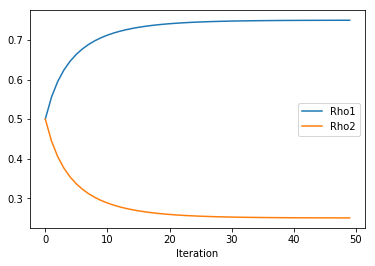

0.74981985698
0.25018014302


In [29]:
import numpy as np
import matplotlib.pyplot as plt

rho1 = 0.5
rho2 = 0.5

lenT1 = 2
lenT2 = 1

rho_1_vec = np.zeros(50)
rho_2_vec = np.zeros(50)

alpha_1_vec = np.zeros(50)
alpha_2_vec = np.zeros(50)

for i in range(0,50):
    rho_1_vec[i] = rho1
    rho_2_vec[i] = rho2
    
    reads1 = 30. + 40.*(rho1)
    reads2 = 40.*(rho2)
    
    alpha1 = reads1 / (reads1 + reads2)
    alpha2 = reads2 / (reads1 + reads2)
    
    alpha_1_vec[i] = alpha1
    alpha_2_vec[i] = alpha2
    
    rho1 = (alpha1 / lenT1) / ((alpha1/lenT1) + (alpha2/lenT2))
    rho2 = (alpha2 / lenT2) / ((alpha1/lenT1) + (alpha2/lenT2))
    
    
    
#     print(i)
#     print(rho1)
#     print(rho2)
    
plt.plot(range(0,50),rho_1_vec)
plt.plot(range(0,50),rho_2_vec)
plt.xlabel('Iteration')
plt.legend(['Rho1', 'Rho2'])
plt.show()
print(rho_1_vec[-1])
print(rho_2_vec[-1])

## How to decide if an algorithm is good
Now that we have an algorithm, what characteristics of it can we examine as we decide whether or not it is "good"?

### 1. Does it converge?
Obviously, we want an algorithm that converges so that we can have our estimates. In this case, the algorithm is guaranteed to converge, although it is not guaranteed to converge in general. In general, it converges if your generative model belongs to the [exponential family](https://en.wikipedia.org/wiki/Exponential_family).


### 2. Is it accurate?
This question is a bit trickier, since it is not an absolute statement we can make about an algorithm, but rather a relative one. As in, we must compare this algorithm to all other algorithms when considering this. In order to answer this, we will first examine the idea of Maximum Liklihood (ML).

Given some reads $R_1, \dots, R_N$, for a given model with parameters $\rho_1, \dots, \rho_k$, we write the probability of observing the reads $R_1, \dots, R_N$ given the parameters $\rho_1, \dots, \rho_k$ as  $Pr(R_1, \dots, R_N$ ; $\rho_1, \dots, \rho_k)$

The idea of Maximum Liklihood is that our model should maximize this probability over the parameters. That is, our model should satisfy

$\max_{\rho_1, \dots, \rho_k} Pr(R_1, \dots, R_N$ ; $\rho_1, \dots, \rho_k)$

This is the idea of Maximum Liklihood, and is pretty much a gold standard when assessing algorithms. As it turns out, this algorithm gives the ML result, so yeah we can say this is a good algorithm.

In particular, this algorithm is a specific instance of the Expectation Maximization (EM) algorithm. This idea will be discussed in future lectures.